We assume the following structure in the folder.

📦directory<br>
┣📂data<br>
┃ ┣ 📂ref<br>
┃ ┣ 📂test _# contains the test data_<br>
┃ ┣ 📂train _# contains the train data_<br>
┃ ┃ ┣ 📂1. neutral*bg<br>
┃ ┃ ┣ 📂2. noisy_bg<br>
┃ ┃ ┣ 📂3. hand<br>
┃ ┃ ┣ 📂4. neutral_bg_outliers<br>
┃ ┃ ┣ 📂5. noisy_bg_outliers<br>
┃ ┃ ┗ 📂6. hand_outliers<br>
┃ ┗ 📂train_coins<br>
┃ ┃ ┗ 📜labels.csv *# contains the labels of the coins in the train data*<br>
┣ 📂img<br>
┃ ┗ 📜image.png *# contains image of the ResNet Architecture*<br>
┣ 📂model<br>
┃ ┗ 📜model.pth *# our final trained model*<br>
┣ 📜classification.py<br>
┣ 📜report.ipynb<br>
┣ 📜requirements.txt *# necessary packages needed to run the `report.ipynb` notebook*<br>
┣ 📜segmentation.py<br>
┗ 📜submission.csv *(OPTIONAL) the test results we submitted on Kaggle\*<br>

The necessary packages can be downloaded by running:

`pip install -r requirements.txt`


Project realized by: 

Jakhongir Saydaliev - 369355

Mohamed Mahfouz Shahaw - 340942

Jean Cordonnier - 314353

In [1]:
#! pip install -r requirements.txt

In [1]:
import os
import sys
import shutil
import random

import torch
from torch import nn
from torchinfo import summary
from torchvision import datasets
from torchvision.models import resnet50, ResNet50_Weights

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv

import warnings
warnings.filterwarnings('ignore')

# set seed
seed=0

# Segmentation


In [3]:
# Set the path to the directory containing the "segmentation" package
package_path = "segmentation"

# Add the package path to PYTHONPATH
os.environ["PYTHONPATH"] = os.pathsep.join([package_path, os.environ.get("PYTHONPATH", "")])

# Update sys.path to include the package path
sys.path.insert(0, package_path)

# The script where we have implemented the necessary functions needed in the segmentation part
from segmentation import segment

Our first try: A tresholding approach. When tackling the segmentation our first reflex was to apply a full scale segmentation on the train test. Our goal in thge beginning was to have the same method for every image type when doing the segmentation. We used the average and standard deviation of the pieces to try to identify the best tresholds for every channel. As you can expect it did not work. We had encouraging results (not false negative, a few false positive) for the "neutral" and "noisy" background alone. But when mixing the treshold it would completely over lap with the noisy background colors. We also had a few false positive for the "neutral" due to the shadows of the the backgroud. And for the hand the results were terrible, and we direcly understood that we would need to go for another method in the future. 

Our seconde try consisted of first detected the background. For this we used a simple method: the standard deviation of the pixels on specific channels. We determined that for every "Noisy" image, the standard deviation on the red channel would be greater than 25, that for a neutral background the standard deviation of the values of the green pixels would be lower than 20. And image not responding to those 2 criterias would then belong to the "hand" background. The method was simple yet efficient, we compared the results for every picture on the train set and we ended up with a 100% accuracy. 

In [5]:
from segmentation import detect_background
#load images
noisy_path = "data\\train\\2. noisy_bg\\L1010325.JPG"
hand_path = "data\\train\\3. hand\\L1010373.JPG"
neutral_path = "data\\train\\1. neutral_bg\\L1010277.JPG"

img_noisy = cv.imread(noisy_path)
img_neutral = cv.imread(neutral_path)
img_hand = cv.imread(hand_path)

# because cv2.imread loads in BGR
img_neutral = cv.cvtColor(img_neutral, cv.COLOR_BGR2RGB)
img_noisy = cv.cvtColor(img_noisy, cv.COLOR_BGR2RGB)
img_hand = cv.cvtColor(img_hand, cv.COLOR_BGR2RGB)

#use the std approach to detect background
print('Neutral is detected as: ',detect_background(img_neutral))
print('Noisy is detected as: ',detect_background(img_noisy))
print('Hand is detected as: ',detect_background(img_hand))

Neutral is detected as:  Neutral
Noisy is detected as:  Noisy
Hand is detected as:  Hand


Then we tried the canny algorithm to tackle the problem with the hand. The canny compute the contours blurring the image and using a sobel filter to detect the edges (on the greyscale image). We took advantage of the double tresholding used to keep the edge intensity that interested us. It worked very well after a bit of tuning on the hand the neutral background (for the last one it also seemed more robust than simple tresholding) but was a pure catastrophy for the noisy background.

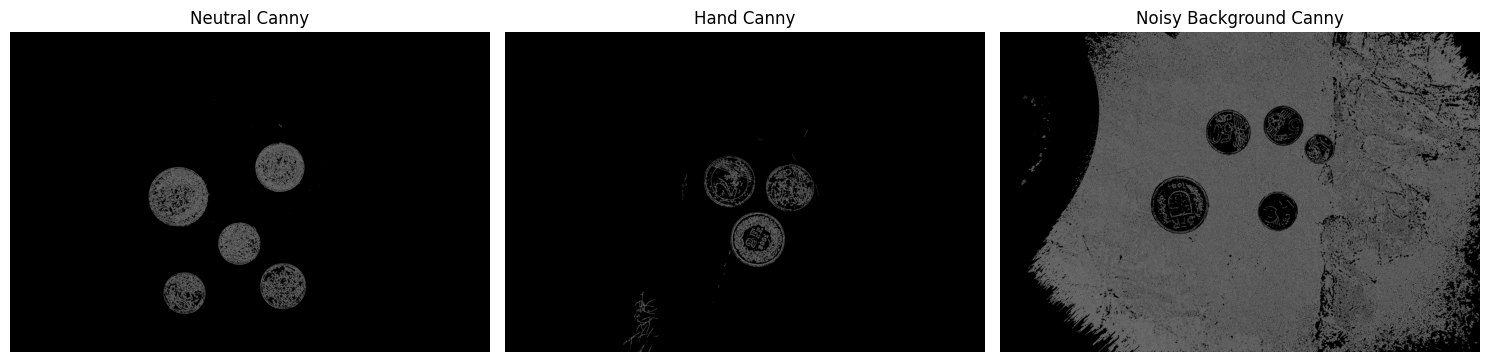

In [6]:
#convert to grayscale algorithm
img_gray_neutral = cv.cvtColor(img_neutral, cv.COLOR_BGR2GRAY)
img_gray_hand = cv.cvtColor(img_hand, cv.COLOR_BGR2GRAY)
img_gray_noisy = cv.cvtColor(img_noisy, cv.COLOR_BGR2GRAY)

#apply canny
#for neutral
img_neutral_canny = cv.Canny(img_gray_neutral, 10, 100, 3)
#for hand
img_hand_canny = cv.Canny(img_gray_hand, 50, 200, 3)
#exceptionnaly we try canny on the noisy background
img_noisy_canny = cv.Canny(img_gray_noisy, 50, 200, 3)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_neutral_canny, cmap='gray')
plt.title('Neutral Canny')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_hand_canny, cmap='gray')
plt.title('Hand Canny')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_noisy_canny, cmap='gray')
plt.title('Noisy Background Canny')
plt.axis('off')

plt.tight_layout()
plt.show()

Canny worked well for noisy and hand background on the whole training set but is not applicable for the noisy background. But now that we can differenciate the backgrounds, we can go back to a simple tresholding approach using the H ans S channel and a bit of fine tuning. We decided to choose a quite big treshold that tend to add noise but take all the pieces into account. Then it uses an '&' operator between the two channels to remove the noise added by the tresholding

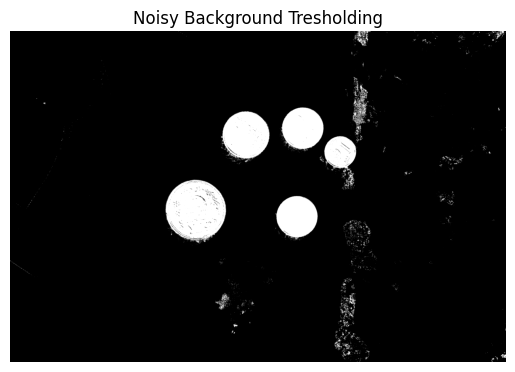

In [7]:
from segmentation import extract_hsv_channels

#load h and s channels
img_h, img_s, _ = extract_hsv_channels(img_noisy)
# 1. -> 255
img_s = np.round((img_s*255),0)
#tresholding in two different zones
img_binary1 = np.where((img_s < 100) | (img_s >255) , 0, 1)
img_binary3 = np.where((img_s < 50) | (img_s >80) , 0, 1)
img_binary1 = img_binary1 | img_binary3
#1. -> 255
img_h= np.round((img_h*255),0)
#tresholding
img_binary2 = np.where((img_h < 10) | (img_h >30) , 0, 1)

#combining the two images
img_noisy_tresh = img_binary2 & img_binary1

plt.imshow(img_noisy_tresh, cmap='gray')
plt.title('Noisy Background Tresholding')
plt.axis('off')
plt.show()

It resulted with clear distinction of the pieces, but we still had noise on every image. To resolve this, it was time time for a little bit of morphology. Each morphology was adapted too each method (wihch means that neutral and hand share the same morphology algorithm). We used the same morpholgy functions than in Lab1 + the dilate function for the images from canny. We resize the images only now since having high definition images for the past steps would not add that much time in the computation and englobe more pixels. Also when we used tresholding after resizing it would result in some extrapolation patterns being present on the image. That's why we did not resized the images before. Additionnaly we prefered to resize them before morphology because it speeds up the computations by a lot without reducing the image quality that much (particulary for binary images)

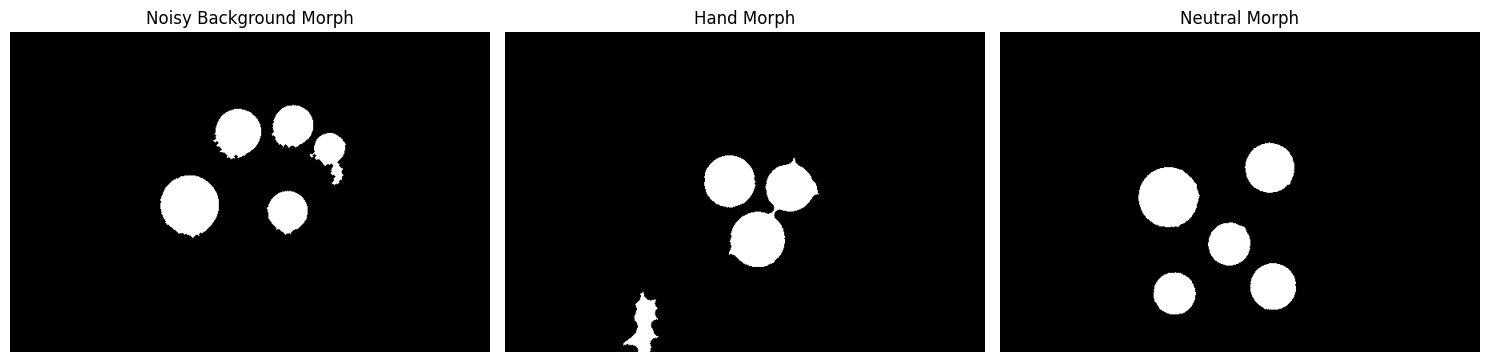

In [8]:
from segmentation import apply_tresh_morpho,apply_tresh_morpho_noisy
#change the format for morphology
img_neutral_canny = img_neutral_canny.astype(np.uint8)*255
img_hand_canny = img_hand_canny.astype(np.uint8)*255
img_noisy_tresh = img_noisy_tresh.astype(np.uint8)*255

#dilation for canny images
img_hand_dilated = cv.dilate(img_hand_canny, (1000, 1000), iterations=10)
img_neutral_dilated = cv.dilate(img_neutral_canny, (1000, 1000), iterations=10)

#resize the images
img_hand_dilated = cv.resize(img_hand_dilated, (600, 400))
img_neutral_dilated = cv.resize(img_neutral_dilated, (600, 400))
img_noisy_tresh = cv.resize(img_noisy_tresh, (600, 400))

#different morphology for tresholding and canny
#used to still apply the same morphology depending on the image quality
ratio = 0.15 

img_noisy_morph = apply_tresh_morpho_noisy(img_noisy_tresh,ratio)
img_hand_morph = apply_tresh_morpho(img_hand_dilated,ratio)
img_neutral_morph = apply_tresh_morpho(img_neutral_dilated,ratio)

# Display the images 
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img_noisy_morph, cmap='gray')
plt.title('Noisy Background Morph')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_hand_morph, cmap='gray')
plt.title('Hand Morph')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_neutral_morph, cmap='gray')
plt.title('Neutral Morph')
plt.axis('off')

plt.tight_layout()
plt.show()



The morphology works but we still have a few issues. First of all there still are some background that was not removed by the morphology. Those background part can be of a similar size than small pieces so it's extremly hard to remove them without also removing small pieces. We tried different morphology methode to get rid of them but it would tend to also decrease the pieces quality for the morphology or removing some pieces.
The two others problem are the pieces "merging" in one object and the background being attached to one piece as the same object. Those singularities are an obstacle to proper object detection. 
To tackle it we used the fact that all pieces in the train set are rond to detect them using Hough transform. This would allow to discriminate pieces from background and separate pieces sharing the same pixels. We also added a function that removes the circles that shared at least 30% of their area to avoid double detection of a coin. We also added a bit of blurr to the image to smooth the shapes and ease the circle detection. 

In [9]:
from segmentation import filter_overlapping_circles
def find_coins(image): #we show it here so that you can see the 
    """
    Find circles in the given image using Hough Circles algorithm
    """
    # Use Hough Circles method to detect circles
    #minimum distance between circles
    minDist = 10
    #params chooses how close to a circle the shape must be
    param1 = 30 
    param2 = 18
    #Radius of the circles
    minRadius = 10
    maxRadius = 80
    
   
    blurred = cv.GaussianBlur(image, (5, 5), 0)
    circles = cv.HoughCircles(
        blurred,
        cv.HOUGH_GRADIENT,
        1,
        minDist,
        param1=param1, 
        param2=param2,
        minRadius=minRadius,
        maxRadius=maxRadius
    )

    if circles is not None:
        # Convert the circle parameters from float to int
        circles = np.round(circles[0, :]).astype("int")

        # Remove overlapping circles
        circles = filter_overlapping_circles(circles)

        return circles
    else:
        print('No coins were found')
        return None

In [10]:
img_noisy_uint8 = np.uint8(img_noisy_morph) * 255
img_hand_uint8 = np.uint8(img_hand_morph) * 255
img_neutral_uint8 = np.uint8(img_neutral_morph) * 255

circles_noisy = find_coins(img_noisy_uint8)
circles_hand = find_coins(img_hand_uint8)
circles_neutral = find_coins(img_neutral_uint8)


Now that we have all the circles for every coin, we just retake them from their original image to send it for features extraction and classification

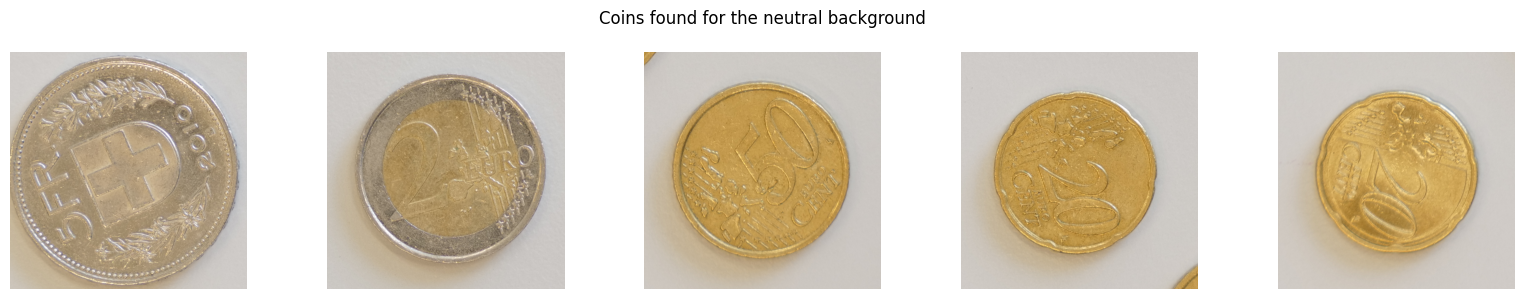

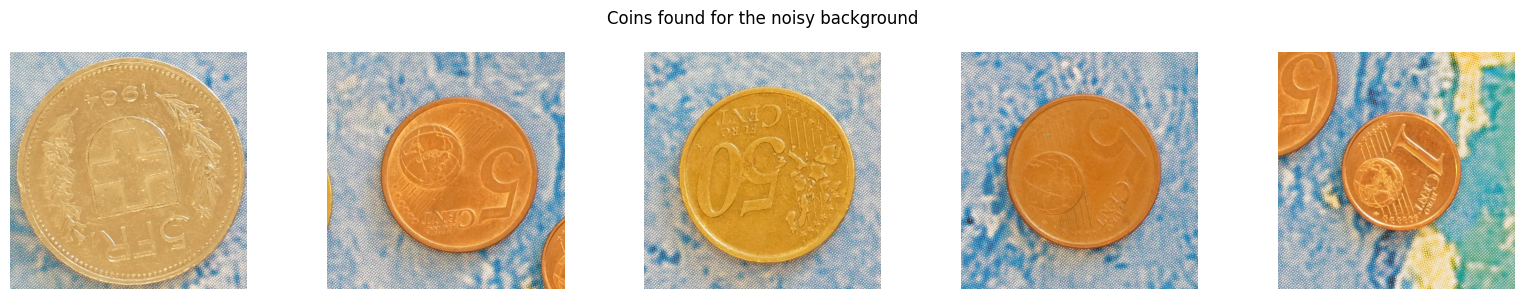

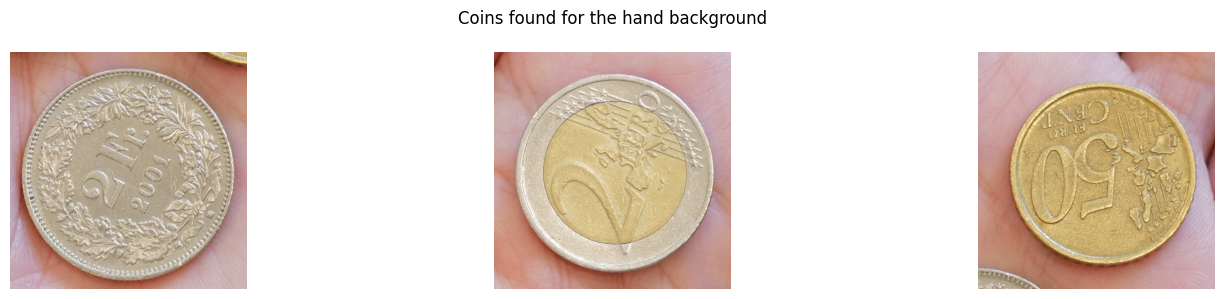

In [11]:
from segmentation import scale_circles_back,extract_circle_regions

#transform the coordinates in the original full scale image
circles_in_original_image_noisy = scale_circles_back(circles_noisy)
circles_in_original_image_hand = scale_circles_back(circles_hand)
circles_in_original_image_neutral= scale_circles_back(circles_neutral)

# extract the coins from the original image
extracted_coins_noisy = extract_circle_regions(img_noisy, circles_in_original_image_noisy)
extracted_coins_hand = extract_circle_regions(img_hand, circles_in_original_image_hand)
extracted_coins_neutral = extract_circle_regions(img_neutral, circles_in_original_image_neutral)

#plot the coins
_, axs = plt.subplots(ncols=len(extracted_coins_neutral), figsize=(16,3))
for i, coin in enumerate(extracted_coins_neutral):
    if len(extracted_coins_neutral) == 1:
        axs.imshow(coin)
        axs.axis('off')
    else:
        axs[i].imshow(coin)
        axs[i].axis('off')
plt.suptitle(f'Coins found for the neutral background')
plt.tight_layout()
plt.show()

_, axs = plt.subplots(ncols=len(extracted_coins_noisy), figsize=(16,3))
for i, coin in enumerate(extracted_coins_noisy):
    if len(extracted_coins_noisy) == 1:
        axs.imshow(coin)
        axs.axis('off')
    else:
        axs[i].imshow(coin)
        axs[i].axis('off')
plt.suptitle(f'Coins found for the noisy background')
plt.tight_layout()
plt.show()

_, axs = plt.subplots(ncols=len(extracted_coins_hand), figsize=(16,3))
for i, coin in enumerate(extracted_coins_hand):
    if len(extracted_coins_hand) == 1:
        axs.imshow(coin)
        axs.axis('off')
    else:
        axs[i].imshow(coin)
        axs[i].axis('off')
plt.suptitle(f'Coins found for the hand background')
plt.tight_layout()
plt.show()


Overall with segmentation on the training set we had two false positive due to the background noise not being correctly removed. We think it would be possible to make the segmentation pipeline more robust using deep learning methods if we had a bigger dataset.

### Train set


To print the plots for all the images provide the `depict_all=True` argument. For example:

```python
segment(folder_path_load="data/train/1. neutral_bg/", depict_all=True)
```


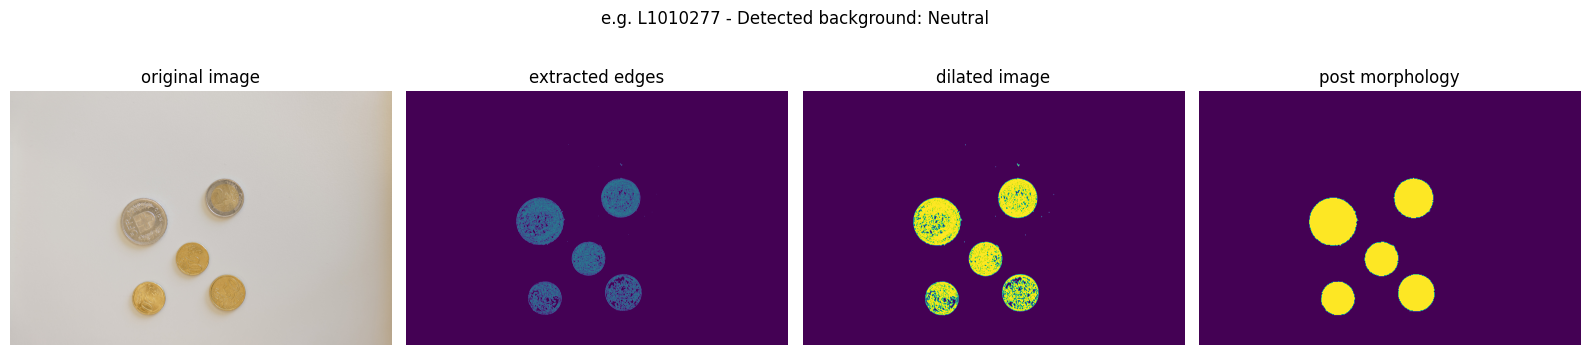

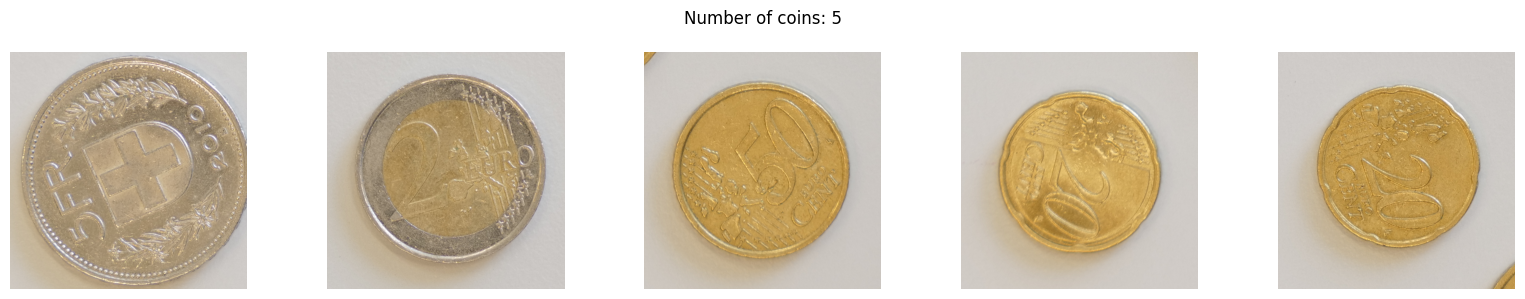

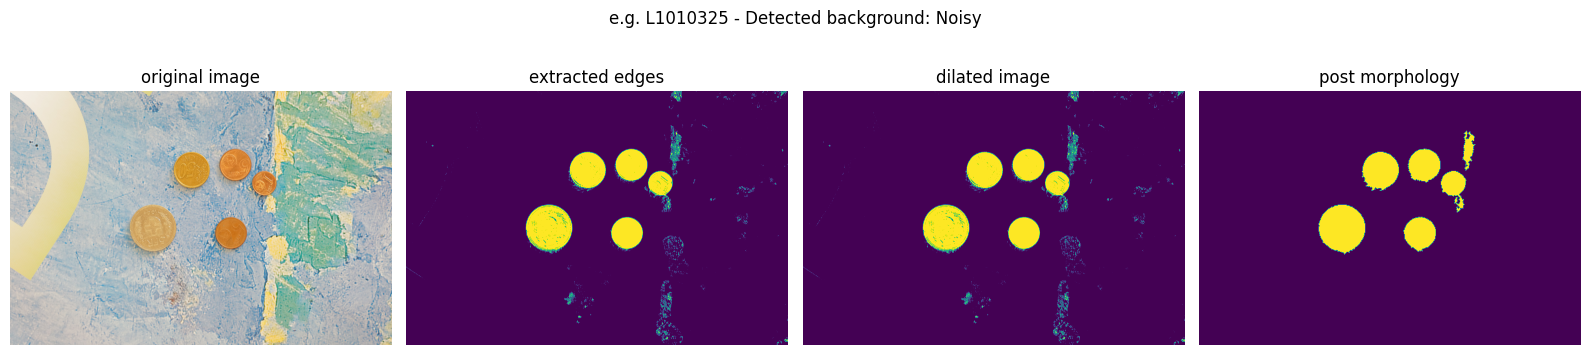

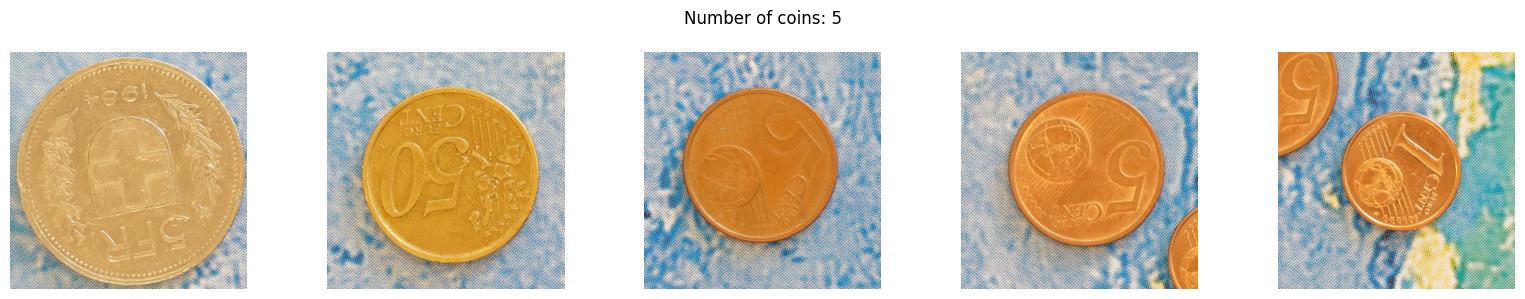

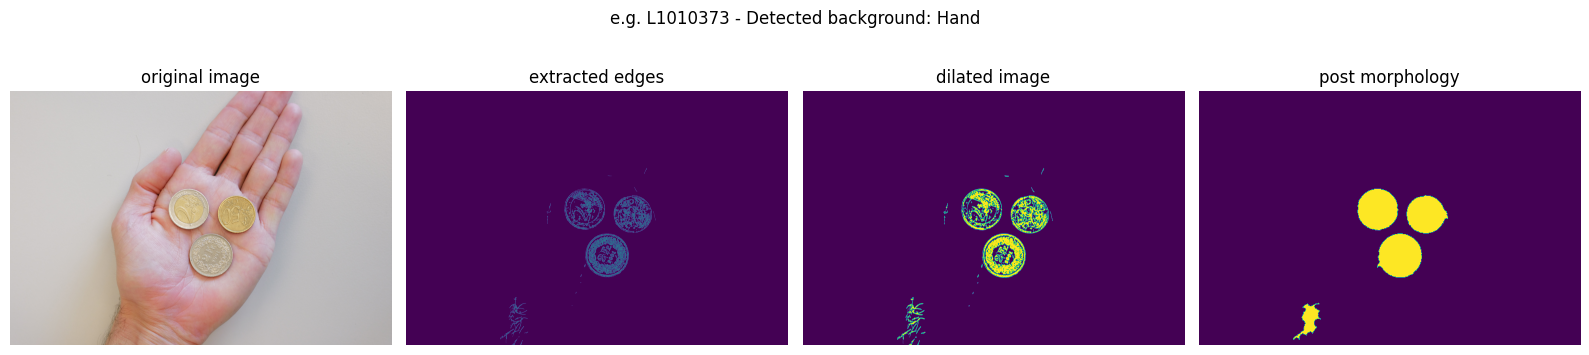

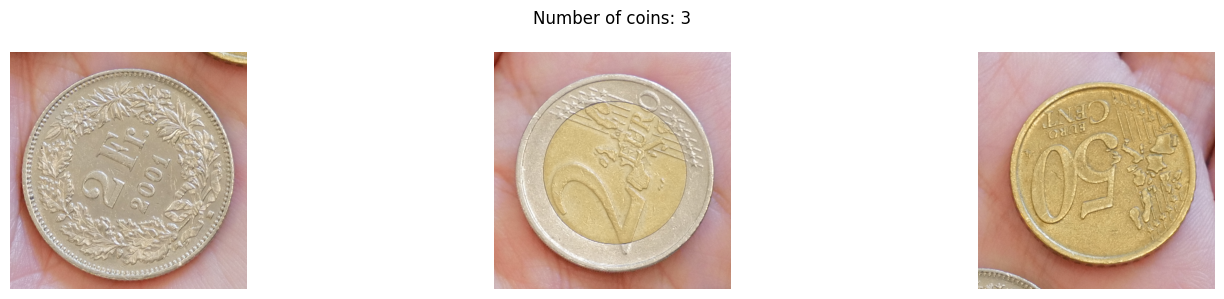

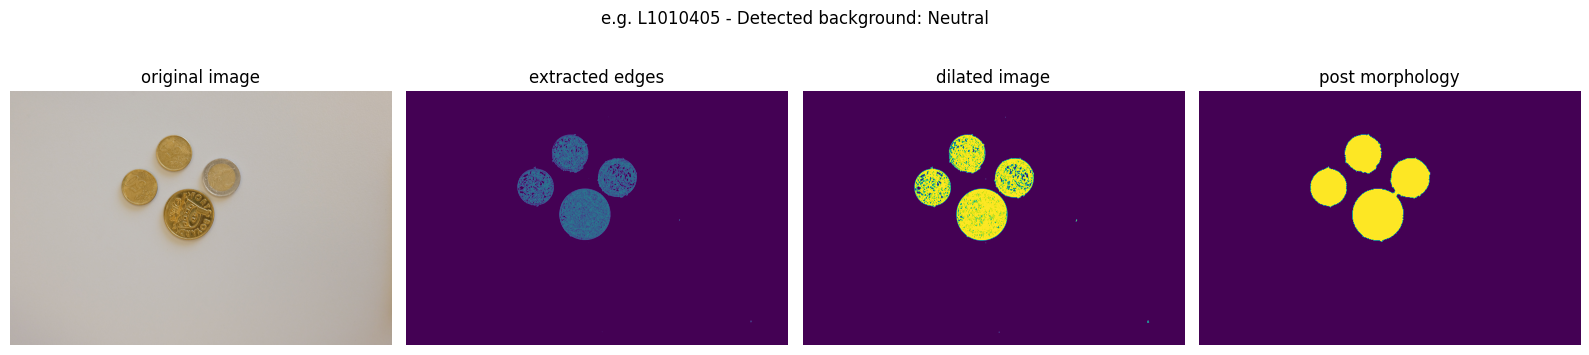

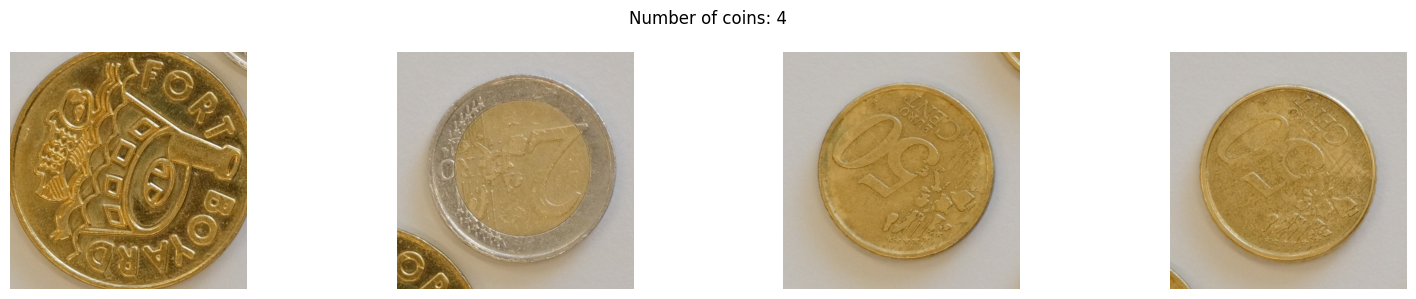

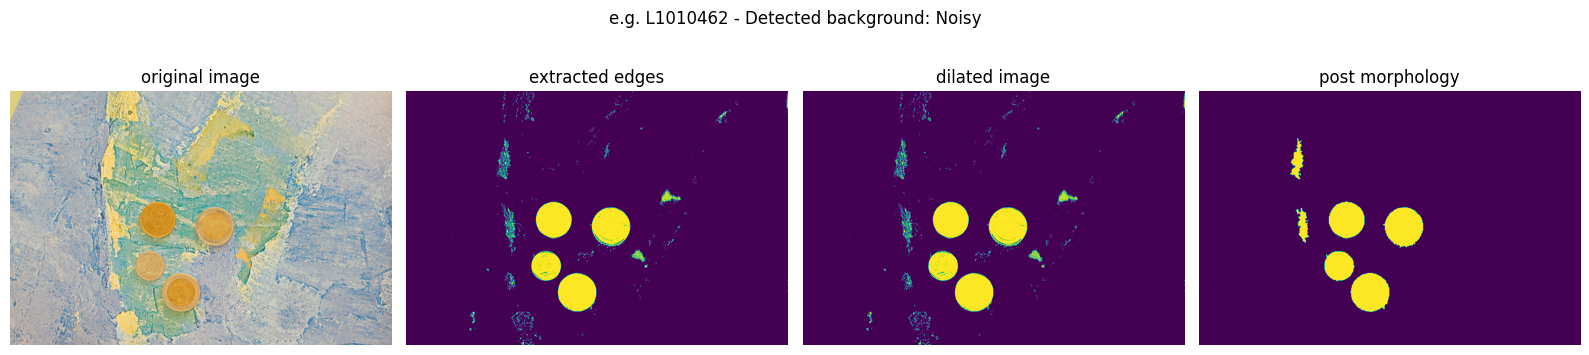

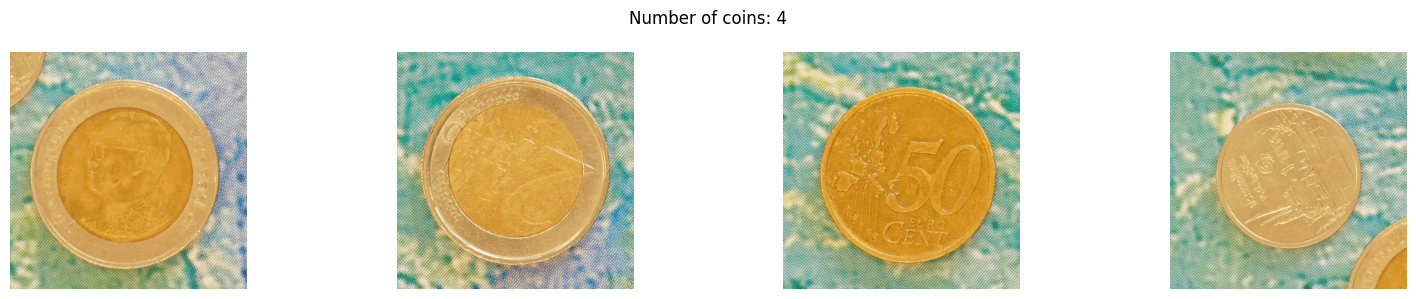

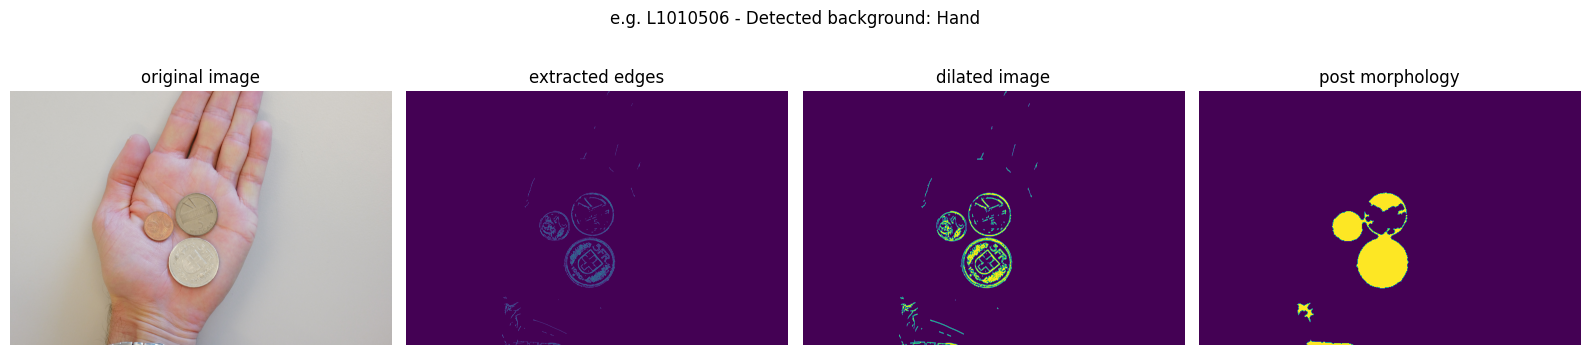

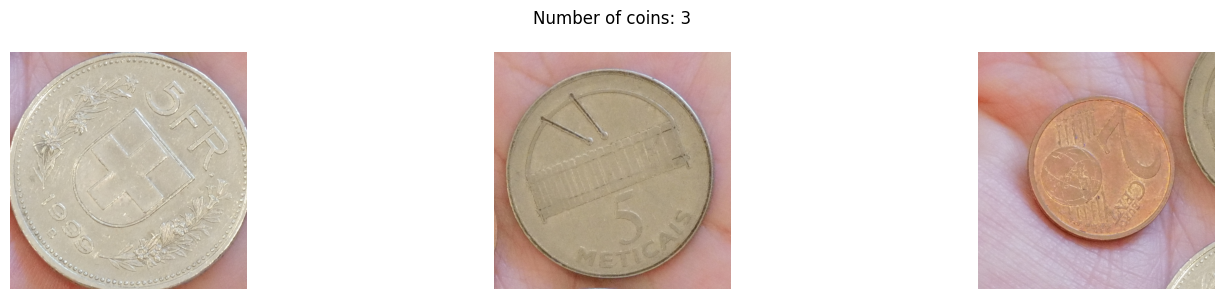

In [12]:
np.random.seed(seed)
random.seed(seed)

# Segment the coins and store them into "data/train_coins/original"
segment(folder_path_load="data/train/1. neutral_bg/", folder_path_save="data/train_coins/original")
segment(folder_path_load="data/train/2. noisy_bg/", folder_path_save="data/train_coins/original")
segment(folder_path_load="data/train/3. hand/", folder_path_save="data/train_coins/original")
segment(folder_path_load="data/train/4. neutral_bg_outliers/", folder_path_save="data/train_coins/original")
segment(folder_path_load="data/train/5. noisy_bg_outliers/", folder_path_save="data/train_coins/original")
segment(folder_path_load="data/train/6. hand_outliers/", folder_path_save="data/train_coins/original")

After segmenting the coins, we did the following steps manually:

- Removed _L1010476_2.JPG_ as it was a false positive.
- Labeled all coins into the `data/train_coins/train_labels.csv` file.

You can just go ahead and execute the below cell, as it moves the coins into the directory of their corresponding labels, laving only _L1010476_2.JPG_ inside `data/train_coins/original` folder. So there is no need for you to do anything manually.

Now, we divide the labeled coins into corresponding class folders.


In [13]:
# Define the directory containing images and the path to the CSV file
images_dir = 'data/train_coins/original'
labeled_dir = 'data/train_coins/labeled'
labels_file = 'data/train_coins/labels.csv'

# Read the CSV file
df = pd.read_csv(labels_file)

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    image_path = row['Image_path']
    image_class = row['Class']

    # Define the source and destination paths
    source_path = os.path.join(images_dir, image_path)
    destination_dir = os.path.join(labeled_dir, image_class)

    # Create the destination directory if it does not exist
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    # Move the image to the destination directory
    destination_path = os.path.join(destination_dir, image_path)
    shutil.move(source_path, destination_path)

### Test set

Let's now segment the coins from the test set, that we will use for inference after the classification training is done.


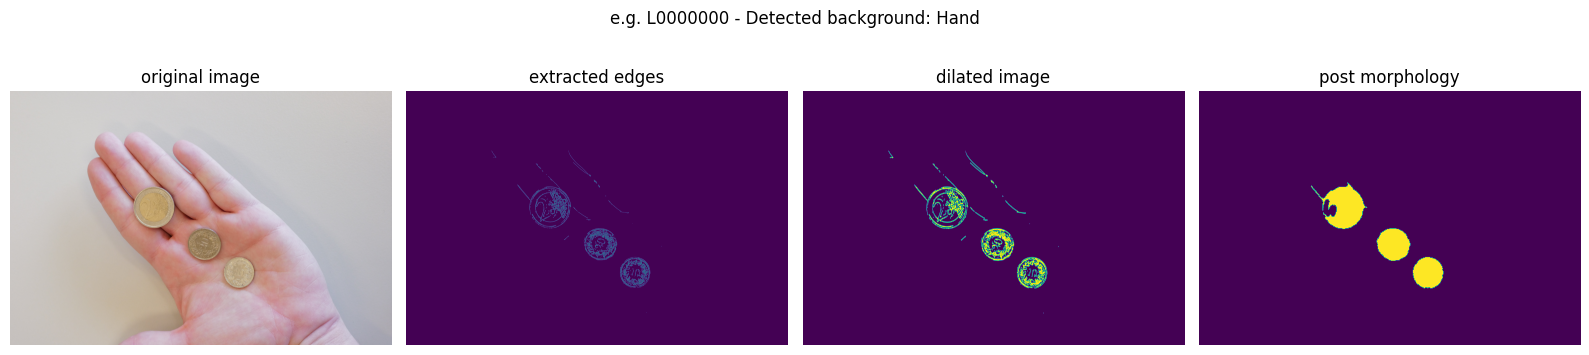

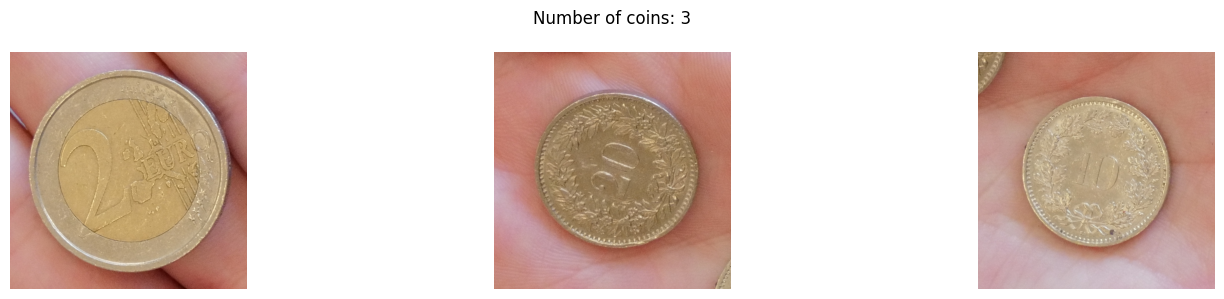

In [ ]:
np.random.seed(seed)
random.seed(seed)

# Segment the coins and store them into "data/test_coins"
segment(folder_path_load="data/test/", folder_path_save="data/test_coins")

# Classification


In [2]:
# The script where we have implemented the necessary functions for classification part
import classification as cls

### Training


For classification, we use a Deep Neural Network, which we explain below, but before training the classifier, we first enrich our training dataset with augmentation of each image.

For each image we create 5 more augmentation to enrich our training dataset. Namely, for each image we apply the following augmentations:

1. Horizontal or Vertical flip with 50% of probability of each.
2. A random rotation between -25 and 25 degrees
3. A random brightness adjustment factor between 0.8 and 1.2
4. A Gaussian noise with a scale randomly chosen between 0 and 0.05 \* 255
5. A random crop of the portions of the image by up to 10% of its size

These randomness of the augmentation ensures a variety of the training data.

Below, we read the labeled dataset from `data/train_coins/labeled` and store them with their corresponding 5 augmented variations into `data/train_coins/augmented` directory.


In [3]:
# Directories
train_dir = "data/train_coins/labeled"
aug_train_dir = "data/train_coins/augmented"

# Process train and test images
cls.process_images(train_dir, aug_train_dir)

For classification, we used a **ResNet50** architecture that is pre-trained on _ImageNet1K_ dataset. ResNet50 is a deep convolutional neural network architecture with 50 layers. It introduces skip connections that skip one or more layers to mitigated the vanishing gradient problem and enabling deeper and more effective models. The architecture can be broken down into 6 parts:

- Convolution layer
- Convolution Block (x4)
- Classification layer

The following is the architecture of ResNet, except ResNet50 Convolution blocks consist of three convolutional layers with batch normalization and ReLU activation after each:

![ResNet architecture](img/image.png "ResNet architecture")


We use _ImageNet1K_v2_ weights that improve upon the results of the original paper by using TorchVision’s new training recipe explained [here](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/).

The inference transforms perform the following preprocessing operations: The images are resized to $232$ using bilinear interpolation, followed by a central crop of size $224$. Finally the values are first rescaled to $[0.0, 1.0]$ and then normalized using $mean=[0.485, 0.456, 0.406]$ and $std=[0.229, 0.224, 0.225]$


We load the ResNet50 architecture, and train only the final classification layer to benefit from its pre-trained weights. We modify the output size to 16, as we have 15 categories of coins, and the OOD coins, that we consider as an additional class.


In [4]:
# Setup Training Directory
train_dir = "data/train_coins/augmented"

# get the available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Running on {device}")

# set seeds for reproducibility
seed=0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# get the pretrained model
model_resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2, progress=True).to(device)
transform_resnet = ResNet50_Weights.IMAGENET1K_V2.transforms()

# freeze all the parameters
for params in model_resnet.parameters():
    params.requires_grad = False

# modify the classifier layer
model_resnet.fc = nn.Linear(in_features=2048, out_features=16, device=device)

Running on cuda


Below, we can see the architecture of ResNet50 and observe that all layers, except the classification layer are, indeed, non-trainable.


In [5]:
# get the summary
summary(model_resnet, input_size=[32, 3, 224, 224], col_names=["input_size", "output_size", 'num_params', 'trainable'], row_settings=["var_names"])

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
ResNet (ResNet)                          [32, 3, 224, 224]         [32, 16]                  --                        Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]         [32, 64, 112, 112]        (9,408)                   False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]        [32, 64, 112, 112]        (128)                     False
├─ReLU (relu)                            [32, 64, 112, 112]        [32, 64, 112, 112]        --                        --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]        [32, 64, 56, 56]          --                        --
├─Sequential (layer1)                    [32, 64, 56, 56]          [32, 256, 56, 56]         --                        False
│    └─Bottleneck (0)                    [32, 64, 56, 56]          [32, 256, 56, 56]         --                        False


We train the model on cross validation using 5 folds. The reason is that we have a limited number of train set, and we want to use all the train data for training our classifier. However, we need to find the optimal hyperparameters (i.e. Learning Rate, Number of Epochs) which we do using cross validation. Once we find the optimal hyperparameters, we train the final model with them.


In [ ]:
# Set Hyperparameters
epochs = 30
lr = 1e-3
batch_size = 8
k_folds = 5
criterion = nn.CrossEntropyLoss()

# Run the training loop with 5 folds
results, best_epoch = cls.train_k_fold(model=model_resnet,
                            train_data_path=train_dir,
                            transform=transform_resnet,
                            loss_fn=criterion,
                            lr=lr,
                            epochs=epochs,
                            device=device,
                            k_folds=k_folds,
                            batch_size=batch_size)

Let's visualize the Train and Test Accuracy / Loss


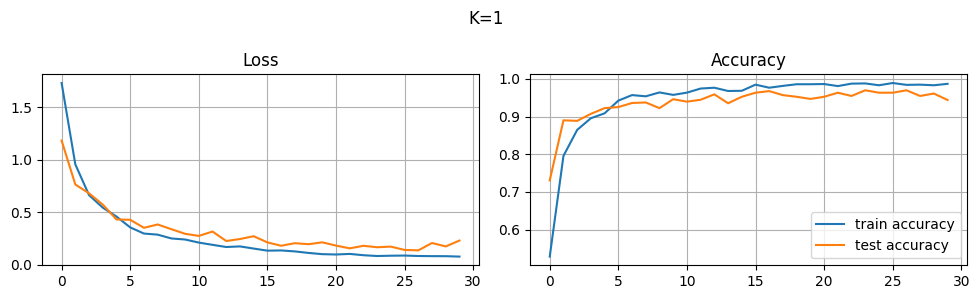

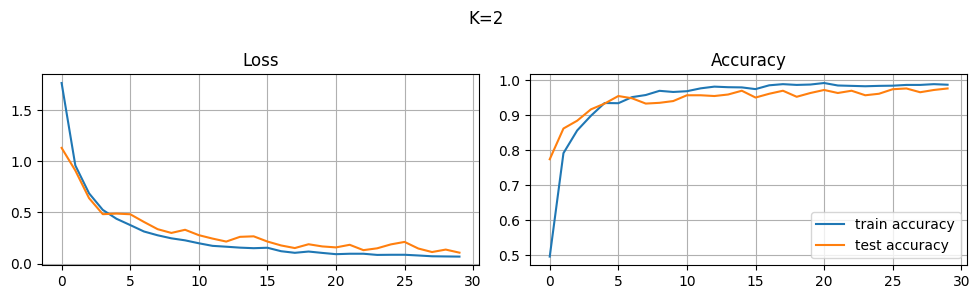

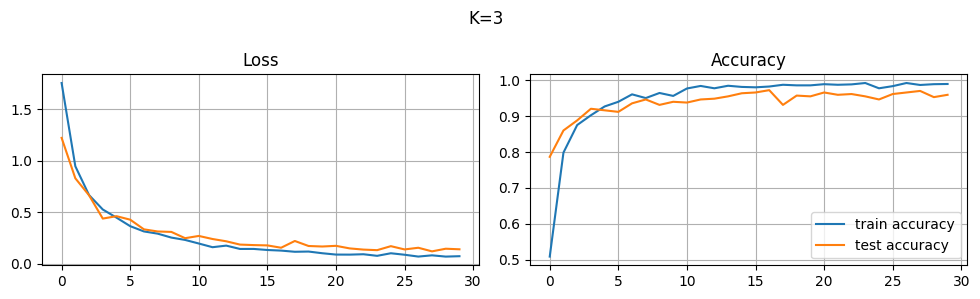

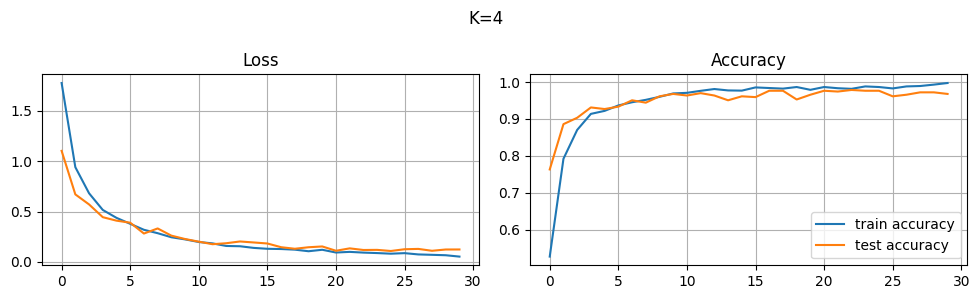

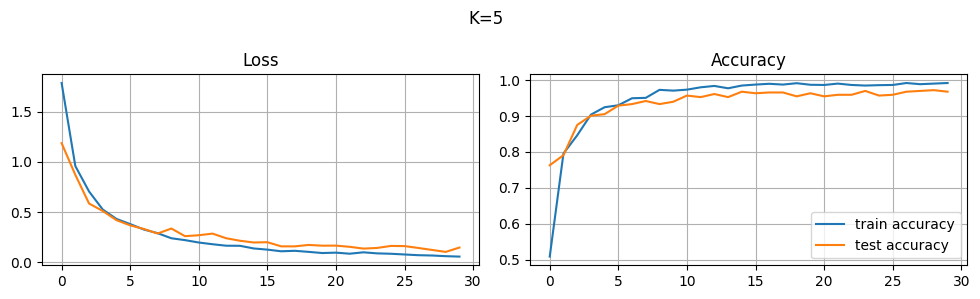

In [7]:
# Plot the training loss and accuracy
for idx, result in enumerate(results):
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    df_result = pd.DataFrame(result)

    axs[0].plot(df_result.train_loss, label='train loss')
    axs[0].plot(df_result.test_loss, label='test loss')
    axs[0].set_title('Loss')
    axs[0].grid()
    axs[1].plot(df_result.train_acc, label='train accuracy')
    axs[1].plot(df_result.test_acc, label='test accuracy')
    axs[1].set_title('Accuracy')
    axs[1].grid()

    plt.suptitle(f'K={idx+1}')
    plt.legend()
    plt.tight_layout()
    plt.show()

Above, we saw that with $LR=10^{-3}$, we constantly achiave ~97% of accuracy on the validation set, and we also found the best epoch, after which the model starts overfitting on the train set.


In [11]:
print("The best epoch:",+best_epoch)

The best epoch: 22


Now we reset the model, and retrain it using the above found best epoch.


In [ ]:
# Train the final model on the whole dataset
print('resetting the parameters of the fully connected layer')
model_resnet.fc.reset_parameters()

results = cls.train_final_model(model=model_resnet,
                                train_data_path=train_dir,
                                transform=transform_resnet,
                                loss_fn=criterion,
                                batch_size=batch_size,
                                lr=lr,
                                epochs=best_epoch,
                                device=device)
# save the model
cls.save_model(model_resnet, "model", 'model.pth')

### Inference


Let's now load the saved model.


In [4]:
# Load the model
model_loaded = cls.load_model(resnet50, model_path="model/model.pth", out_features=16)

# Get the class names
transform_resnet = ResNet50_Weights.IMAGENET1K_V2.transforms()
class_names = datasets.ImageFolder(train_dir, transform=transform_resnet).classes

[INFO] Loaded model from: model\model.pth


Now, we try the classifier on a few samples from th test set and see how it performs.


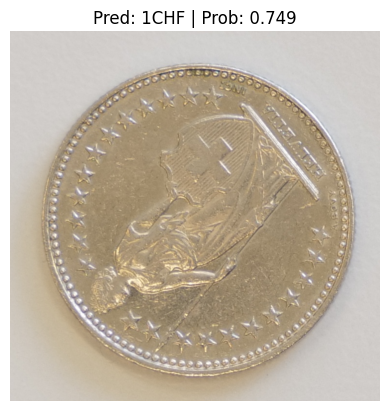

In [20]:
# Test the model
cls.pred_and_plot_image(model_loaded, class_names, 'data/test_coins/L0000001_0.JPG', transform_resnet, )

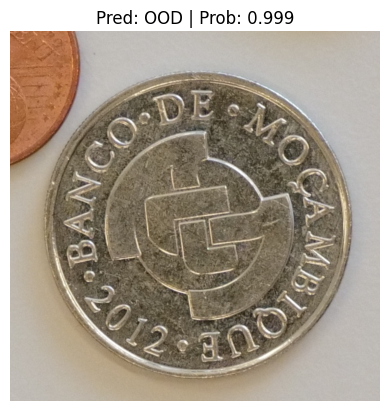

In [21]:
# Another test
cls.pred_and_plot_image(model_loaded, class_names, 'data/test_coins/L0000003_1.JPG', transform_resnet, )

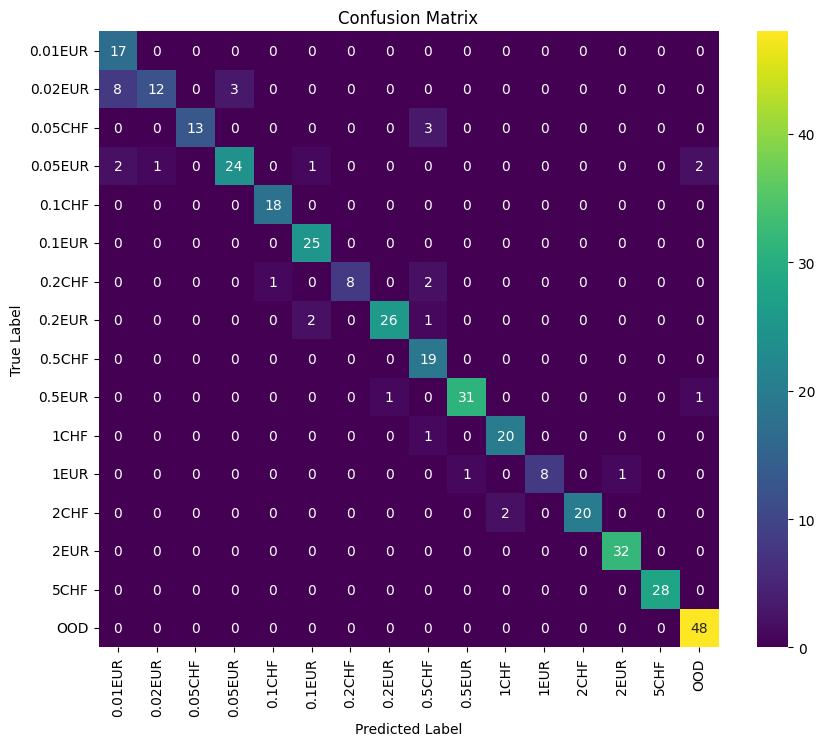

In [5]:
from classification import evaluate_model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path_to_train_coins_labeled = 'data/train_coins/labeled'

#confusion matrix
evaluate_model(model_loaded, path_to_train_coins_labeled, device)


From the confusion matrix evaluated on the whole training set, we can easily see the pattern of misclassification. Indeed, pieces with similar numbers/pattern, colors or size can easily be mis-classified (e.g : 0.02 misclassified as 0.01 or 0.05). We can not that the OODs are very well classified.

Now, we use the model for predicting the class of all the coins in the test set, and prepare a submission file.


In [ ]:
# Get prediction of all the test set
prediction_list = cls.pred_and_return_labels(model_loaded, class_names, 'data/test_coins', transform_resnet)

# Clean the predictions
prediction_clean = [[idx.split("_")[0], val] for idx, val in prediction_list.items()]

# Get unique image names
unique_image_paths = np.unique([pred[0] for pred in prediction_clean])

# Initialize the submission DataFrame with zeros
submission = pd.DataFrame(index=unique_image_paths, columns=list(reversed(class_names))).fillna(0)

# Populate the submission DataFrame with the predictions
for img_path, class_name in prediction_clean:
    submission.loc[img_path, class_name] += 1

# Set the index name as `id`
submission.index.name = 'id'

# Save the submission DataFrame to a CSV file
submission.to_csv("submission.csv")

There we go, we can now go ahead and submit it on Kaggle!
